# Analyses of entanglement


### "Sweep through generative factors and plot/quantify effect in the latents"


In [1]:
import torch
import pickle

import sys
# Adds higher directory to python modules path.
sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

sys.path.append("../analyses")
from analyses import *

### model: staticVAE32 (standard VAE)


In [2]:
from staticvae.models import staticVAE32

vae = staticVAE32(n_latent = 4)
vae.eval()
checkpoint = torch.load('../staticvae/trained/staticvae32_dsprites_circle_last_500K',map_location='cpu')
vae.load_state_dict(checkpoint['model_states']['net'])

training_stats = pickle.load(open('../staticvae/trained/staticvae32_dsprites_circle_500K.pkl', 'rb'))

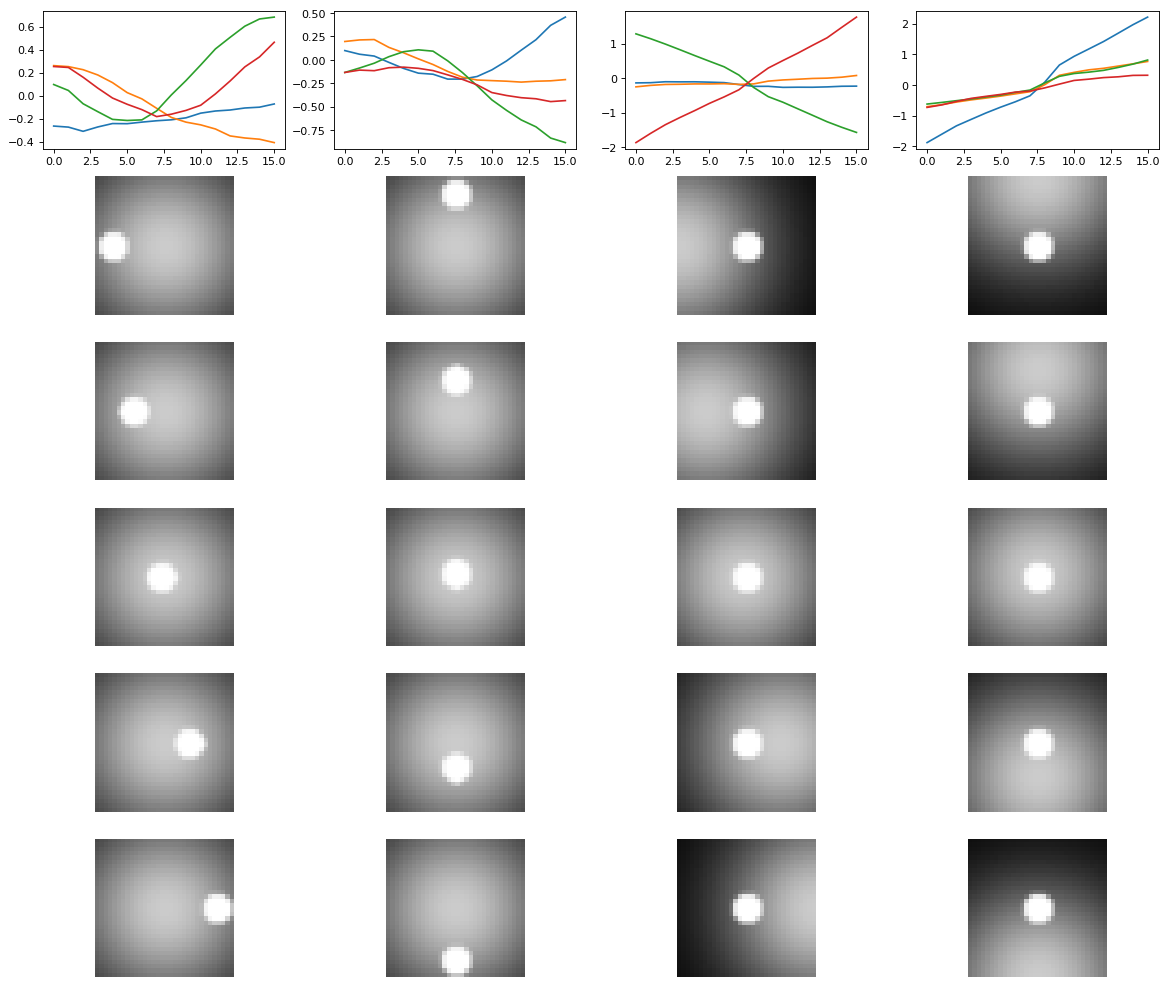

In [48]:
yhat_vae, x_vae = sweepCircleLatents(vae)
plotCircleSweep(yhat_vae, x_vae)

#### Plot correlation matrix

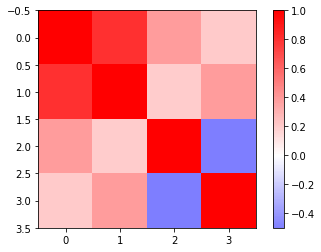

In [59]:
corr_vae = np.corrcoef(yhat_vae.detach().numpy().T)
# Plot covariance
plt.set_cmap('bwr')
plt.imshow(corr_vae)
colorAxisNormalize(plt.colorbar())

There is significant cross-correlation (positive and negative) between some, but not all latent variables, indicating some entanglement.

### model: $\beta$-VAE-like *supervised* encoder


In [3]:
from supervised_encoderdecoder.models.encoders import encoderBVAE_like

supervised = encoderBVAE_like(n_latent=4)

checkpoint = torch.load('../supervised_encoderdecoder/trained/encoderbvae_like_dsprites_circle_last_50K', map_location=torch.device('cpu'))
supervised.load_state_dict(checkpoint['model_states']['net'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

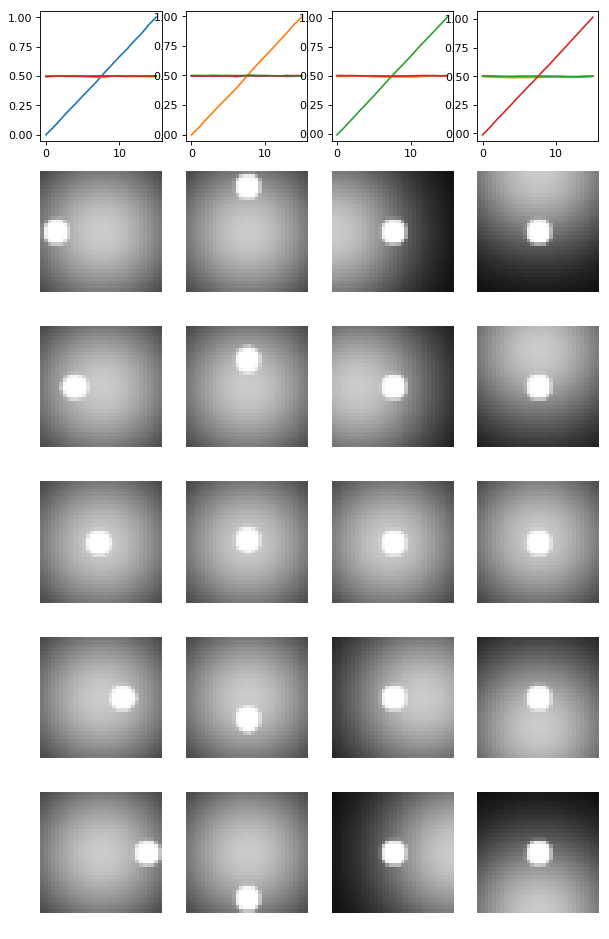

In [4]:
yhat_sup, x_sup = sweepCircleLatents(supervised)
_ = plotCircleSweep(yhat_sup, x_sup)

Same as previous figure, but for supervised encoder.

***Supervised latent representations are perfectly disentangled.***

This was to be expected, but good to validate.

#### Plot correlation matrix

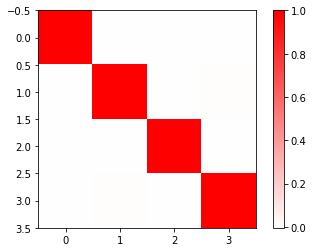

In [5]:
corr_sup = np.corrcoef(yhat_sup.detach().numpy().T)
# Plot covariance
plt.set_cmap('bwr')
plt.imshow(corr_sup)
colorAxisNormalize(plt.colorbar())

As seen from latent plots, there is no cross-correlation between latent variables, indicating perfect disentanglement

### model: $\beta$-VAE


In [6]:
from bVAE.models import staticVAE32,beta_from_normalized_beta
normalized_beta_values = np.logspace(np.log(.001), np.log(5), 6, base=np.e)

bvae = list()
training_stats = list()
for ii,beta_norm in enumerate(normalized_beta_values):

    # beta values in the file name of checkpoints have varying number of decimal points (not so smart)
    beta_norm_str = '%0.4f' % (beta_norm)
    while beta_norm_str[-1] == '0' and beta_norm_str[-2] != '.':
        beta_norm_str = beta_norm_str[:-1]
    
    trainedpath = '../bVAE/trained/staticvae32_betanorm=%s_dsprites_circle_last_500K' % (beta_norm_str)
    trainstatspath = '../bVAE/trained/staticvae32_betanorm=%s_dsprites_circle_500K.pkl' % (beta_norm_str)
    
    bvae.append(staticVAE32(n_latent = 4))
    checkpoint = torch.load(trainedpath, map_location=torch.device('cpu'))
    bvae[ii].load_state_dict(checkpoint['model_states']['net'])

    training_stats.append(pickle.load(open(trainstatspath, 'rb')))

In [7]:
N = bvae[0].img_channels * 32 * 32
M = bvae[0].n_latent
beta = beta_from_normalized_beta(normalized_beta_values, N = N, M = M)

for ii,nb in enumerate(normalized_beta_values):
    print(['betanorm = %0.3f / beta = %0.1f' % (normalized_beta_values[ii],beta[ii])])

['betanorm = 0.001 / beta = 0.3']
['betanorm = 0.005 / beta = 1.4']
['betanorm = 0.030 / beta = 7.7']
['betanorm = 0.166 / beta = 42.4']
['betanorm = 0.910 / beta = 233.0']
['betanorm = 5.000 / beta = 1280.0']


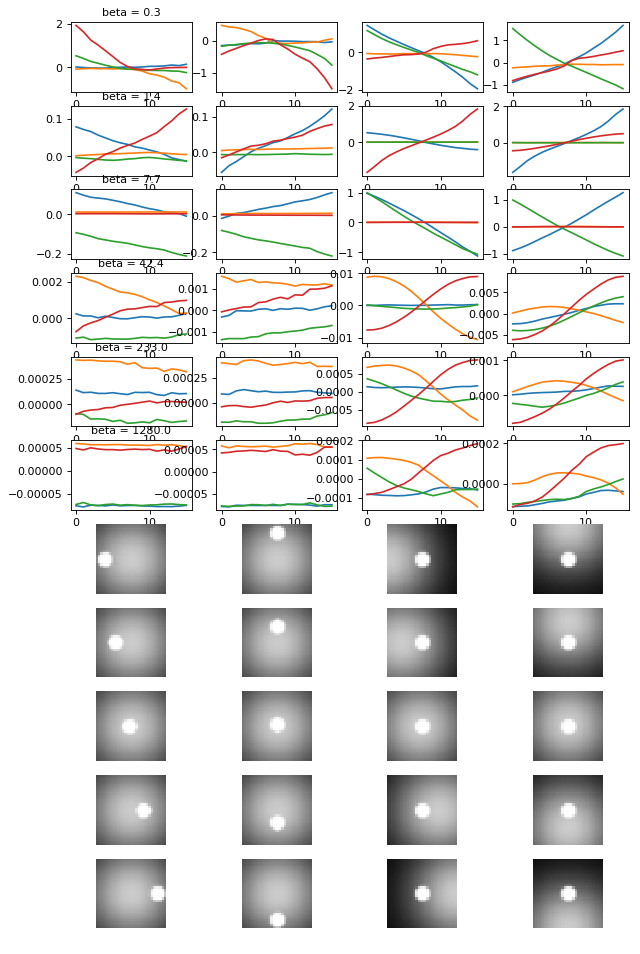

In [58]:
yhat_bvae = list()

for i in range(len(beta)):
    tmpyhat, x_bvae = sweepCircleLatents(bvae[i])
    yhat_bvae.append(tmpyhat)
  
fig,ax = plotCircleSweep(yhat_bvae, x_bvae, len(bvae))
for i in range(len(bvae)):
    plt.sca(ax[i,0])
    plt.title('beta = %0.1f' % beta[i],fontsize=10)

Columns, from left to right: sweeps through circle horizontal position, circle vertical position, gaussian background horizontal position, gaussian background vertical position

Top rows show latent variable representations as a function of the stimulus sweeps, with each row corresponding to a different beta.

***VAE latent representations are entangled.***

Though the x and y position variables are at least monotonically changing---a step towards distentanglement---in the beta = 7.7-42.4 range.

#### Plot correlation matrices

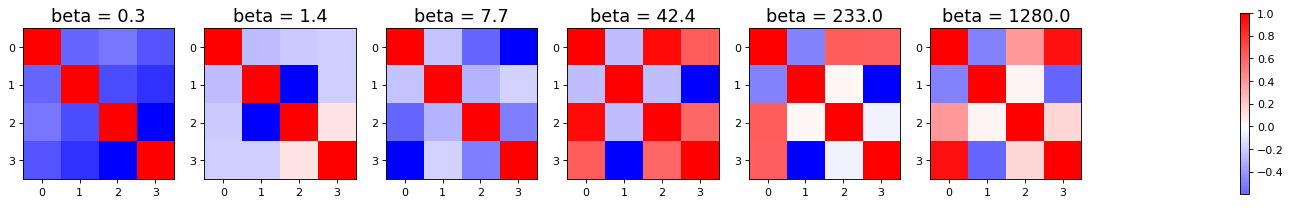

In [75]:
fig, ax = plt.subplots(1,len(beta)+1,figsize=(20,3),
                       dpi= 80, facecolor='w', edgecolor='k')

mss = list()
for i in range(len(beta)):
    corr_sup = np.corrcoef(yhat_bvae[i].detach().numpy().T)
    # mean of squared off-diagonal elements
    mss.append(np.mean((corr_sup-np.eye(4))**2))
    
    # Plot covariance
    plt.sca(ax[i])
    plt.set_cmap('bwr')
    plt.imshow(corr_sup)
    plt.title('beta = %0.1f' % beta[i],fontsize=16)
    
plt.sca(ax[i+1])
ax[i+1].axis('off')
colorAxisNormalize(plt.colorbar())

Text(0, 0.5, 'mean squared cross-correlations')

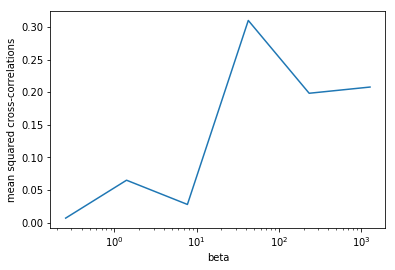

In [82]:
plt.plot(beta,mss)
plt.xscale('log')
plt.xlabel('beta')
plt.ylabel('mean squared cross-correlations')

**Entanglement seems to increase for increasing beta.**

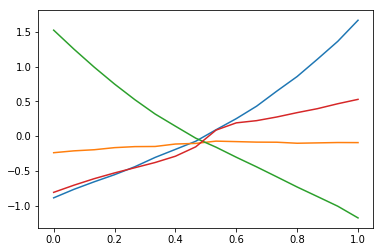

In [57]:
sweep = np.linspace(0,1,16)
yhat_bvae[0] = yhat_bvae[0].reshape(4,16,4)
# plt.plot(sweep,
# plt.plot(yhat_bvae[0].detach().numpy())
plt.plot(sweep,yhat_bvae[0][3,:,:].detach().numpy())

## Analyzing posterior variance

In [88]:
recon, mu, logvar = vae(x_vae)

/home/zaharia/anaconda_envs/pytorchenv/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [91]:
np.var(logvar.detach().numpy(),axis=0)

array([0.29642633, 0.2804733 , 0.28123114, 0.20029241], dtype=float32)

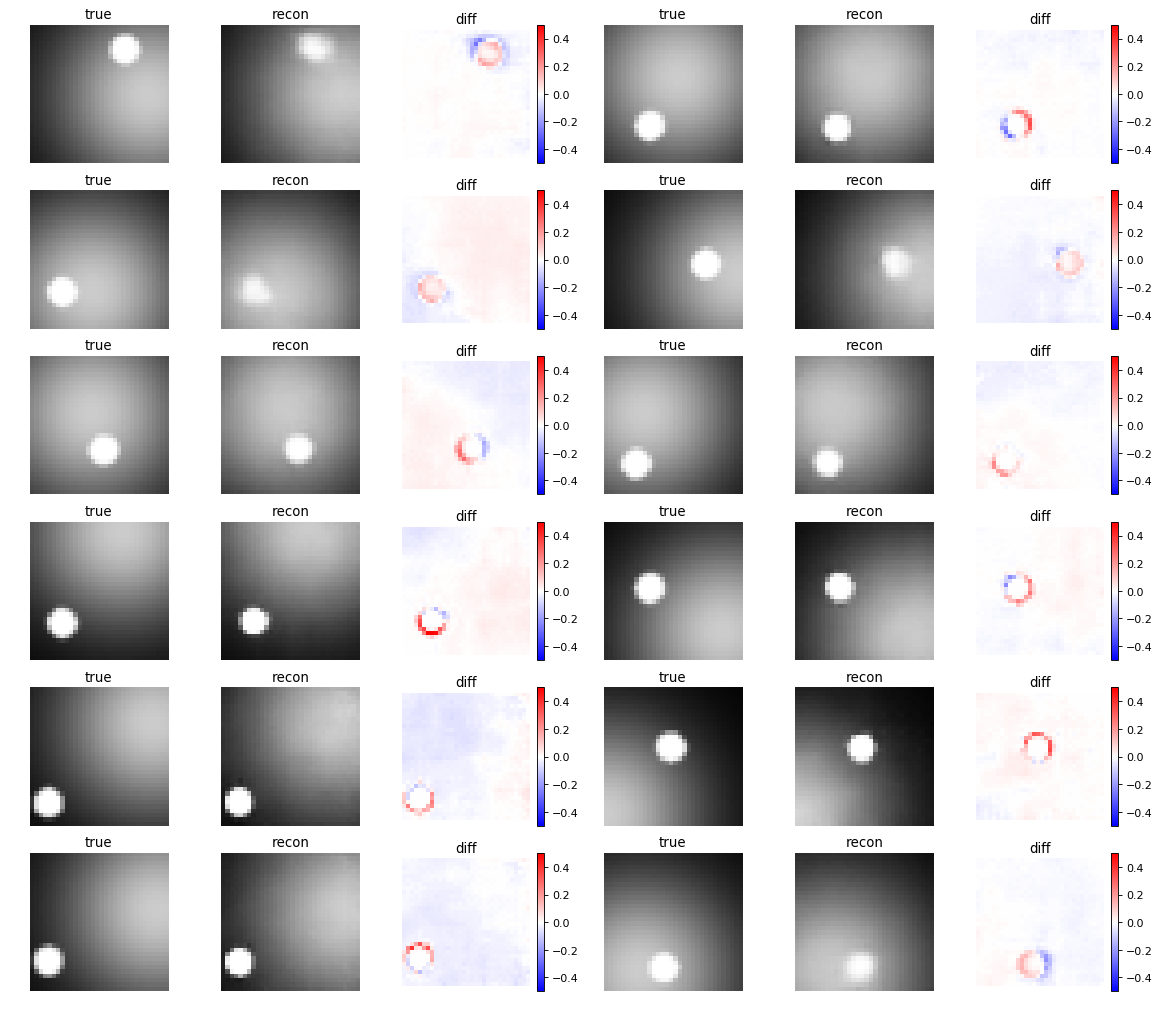

In [83]:
showReconstructionsAndErrors(vae)